# pNEUMA simulator

Data from: https://open-traffic.epfl.ch

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})) \},$ \
$V'(s) = H(s -s_{\text{jam}})\lambda\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{\text{jam}},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +\sigma_R\sqrt{2 b^{-1}} \xi_n,\ b>0,\\
    \dot v_n = \tau_n^{-1}[{( V_n(s_n)+\varepsilon_n)\times w(\Delta t)-v_n}],\ \tau_n>0,\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{(V_n(s_n) +\varepsilon_n(t+\delta))\times w(\Delta t)-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{\text{des}} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_{\text{des}}-\alpha\right]
\end{equation}$

In [1]:
import os
import json
import zipfile
import logging
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from joblib import Parallel, delayed
from matplotlib import rcParams
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.stats import linregress
from numpy.polynomial import Polynomial
from numpy import array, arange, where
from math import exp

In [2]:
from pNeuma_simulator import params
from pNeuma_simulator.initialization import PoissonDisc
from pNeuma_simulator.simulate import batch
from pNeuma_simulator.results import normalized, loader, aggregate, percolate, zipdir, confidence_interval
from pNeuma_simulator.animations import ring

In [3]:
warnings.filterwarnings("ignore")
rcParams["animation.embed_limit"] = 2**128
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

## 2D simulator

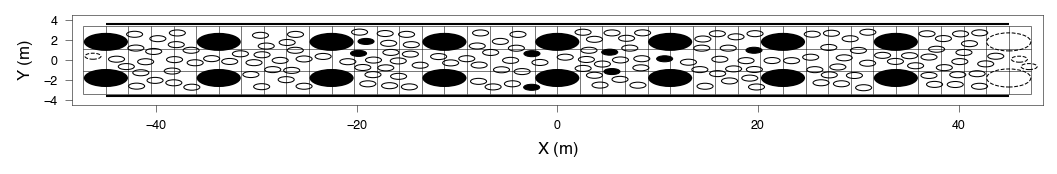

In [4]:
# Pseudorandom number generator
seed = 1
rng = np.random.default_rng(seed)
n_cars = 8
n_moto = 8
sampler = PoissonDisc(
    n_cars, n_moto, cell=params.cell, L=params.L, W=params.cell * 3, k=params.k, clearance=params.clearance, rng=rng
)
samples, images = sampler.sample(rng)
c_samples = samples[: 2 * n_cars]
m_samples = samples[2 * n_cars :]
markings = arange(-sampler.W / 2, 3 * sampler.W / 4, sampler.W / 2)

fig, ax = plt.subplots(figsize=(2 * 8.7 * params.cm, 2.5 * params.cm), dpi=150)
ax.set_aspect("equal")
for sample in samples:
    if sample in c_samples:
        sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.6}
    else:
        sample.styles = {"ec": "k", "fill": False, "lw": 0.5}
    sample.draw(ax)
for image in images:
    image.styles = {"ec": "k", "fill": False, "lw": 0.5, "ls": "--"}
    image.draw(ax)
for m_sample in rng.choice(m_samples, n_moto, replace=False):
    m_sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.5}
    m_sample.draw(ax)
ax.hlines(
    [-params.lane, params.lane],
    xmin=-sampler.width / 2,
    xmax=sampler.width / 2,
    color="k",
    ls="-",
    lw=1,
)
ax.vlines(
    sampler.x_boundaries,
    ymin=-3 * sampler.cell / 2,
    ymax=3 * sampler.cell / 2,
    color="k",
    lw=0.25,
)
ax.hlines(
    sampler.y_boundaries,
    xmin=-sampler.nx * sampler.cell / 2,
    xmax=sampler.nx * sampler.cell / 2,
    color="k",
    lw=0.25,
)
plt.xlim(-(sampler.nx + 1) * sampler.cell / 2, (sampler.nx + 1) * sampler.cell / 2)
plt.ylim(-2 * sampler.cell, 2 * sampler.cell)
ax.set_xlabel("X ($m$)")
ax.set_ylabel("Y ($m$)")
ax.set_yticks(arange(-4, 5, 2))
fig.tight_layout(pad=0)

In [5]:
samples[-1].encode()

{'ID': 170,
 'mode': 'Moto',
 'a_des': 0,
 'a0': 0,
 'ttc': None,
 'f_a': None,
 'leader': None,
 'gap': None,
 'tau': None,
 'lam': None,
 'v0': None,
 'd': None,
 'pos': array([-2.55501897, -2.72772209]),
 'vel': array([0., 0.]),
 'theta': np.float64(0.0),
 'interactions': []}

In [6]:
param = {"const": 4.026397, "x1": -0.062306}
phi_max = int(exp(param["x1"] * 0 * params.factor + param["const"]))
phi_max

56

In [7]:
# Space discretization
x = arange(-params.L / 2 + params.grid / 2, params.L / 2, params.grid)
y = arange(-params.lane - params.grid / 2, params.lane + params.grid, params.grid)
xv, yv = np.meshgrid(x, y)
yv = np.flip(yv)
shape = yv.shape

In [8]:
path = "./output/"
os.makedirs(path, exist_ok=True)
# Combinatorial configurations
n_veh = 4
scale = 2
l_cars = scale * arange(1, n_veh, 1)
l_moto = scale * arange(0, n_veh - 1, 1)
permutations = list(itertools.product(l_cars, l_moto))
len(permutations)

9

In [10]:
run = True
# TODO: update code to match function in new version
epochs = 8
default_rng = np.random.default_rng(1024)
seeds = default_rng.integers(1e8, size=epochs * len(permutations))
if run:
    with Parallel(n_jobs=-1, prefer="processes") as master:
        for n, permutation in tqdm(enumerate(permutations)):
            start = n * epochs
            end = (n + 1) * epochs
            items = master(
                delayed(batch)(seed, permutation) for seed in seeds[start:end]
            )
            # Dump result to a JSON data specification
            with open(f"{path}{permutation}.json", "w") as outfile:
              json.dump(items, outfile)
            # Compress as Zip and delete original JSON
            with zipfile.ZipFile(
                f"{path}{permutation}.zip", "w", zipfile.ZIP_DEFLATED
            ) as zipf:
                zipdir(path, zipf)
            print(permutation)
            items = None

0it [00:00, ?it/s]

(np.int64(2), np.int64(0))
(np.int64(2), np.int64(2))
(np.int64(2), np.int64(4))
(np.int64(4), np.int64(0))
(np.int64(4), np.int64(2))
(np.int64(4), np.int64(4))
(np.int64(6), np.int64(0))
(np.int64(6), np.int64(2))
(np.int64(6), np.int64(4))


# Results

In [11]:
# consider only this last fraction of the simulated data
keep = 1 / 3

In [12]:
# read = not run
# path = "./output/"
# os.makedirs(path, exist_ok=True)
# if read:
#     with open(f"{path}results.json", "r") as openfile:
#         results = json.load(openfile)

In [13]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [13]:
compilation = True
if compilation:
    results = {}
    for permutation in permutations:
            n_cars, n_moto = permutation
            results[str(permutation)] = {
                "VKT_cars": [],
                "VHT_cars": [],
                "VKT_moto": [],
                "VHT_moto": [],
            }
            items = loader(permutation, path)
            accidents = 0
            for item in items:
                if isinstance(item[0], list):
                    (
                        VKT_cars,
                        VHT_cars,
                        VKT_moto,
                        VHT_moto,
                    ) = aggregate(item[0], n_cars, n_moto)
                    results[str(permutation)]["VKT_cars"].append(VKT_cars)
                    results[str(permutation)]["VHT_cars"].append(VHT_cars)
                    results[str(permutation)]["VKT_moto"].append(VKT_moto)
                    results[str(permutation)]["VHT_moto"].append(VHT_moto)
                else:
                    accidents += 1
            error = accidents / len(items)
            results[str(permutation)]["error"] = error
            if n_cars > 2 and n_moto > 2:
                percolation = percolate(items, n_moto, rng, start=5)
            else:
                percolation = None
            results[str(permutation)]["percolation"] = percolation
            items = None

(np.int64(2), np.int64(0)).json
(np.int64(2), np.int64(2)).json
(np.int64(2), np.int64(4)).json
(np.int64(4), np.int64(0)).json
(np.int64(4), np.int64(2)).json
(np.int64(4), np.int64(4)).json
(np.int64(6), np.int64(0)).json
(np.int64(6), np.int64(2)).json
(np.int64(6), np.int64(4)).json


In [14]:
write = True
path = "./output/"
os.makedirs(path, exist_ok=True)
if write:
    with open(f"{path}results.json", "w") as outfile:
        json.dump(results, outfile)

In [18]:
read = not run
path = "./output/"
os.makedirs(path, exist_ok=True)
if read:
    with open(f"{path}results.json", "r") as openfile:
        results = json.load(openfile)

In [ ]:
# for permutation in permutations:
#     str_permutation = str(permutation)
#     print(f"Permutation: {permutation}")

In [15]:
l_flow_cars = []
l_flow_moto = []
l_speed_cars = []
l_speed_moto = []
l_sem_cars = []
l_sem_moto = []
l_error = []
for permutation in permutations:
    flow_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / (
        2e-6 * keep * params.T * params.L / params.factor
    )
    speed_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / np.nanmean(
        results[str(permutation)]["VHT_cars"]
    )
    sem_cars = confidence_interval(results[str(permutation)]["VKT_cars"], rng) / np.nanmean(
        results[str(permutation)]["VHT_cars"]
    )
    if permutation[1] > 0:
        flow_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / (
            2e-6 * keep * params.T * params.L / params.factor
        )
        speed_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
        sem_moto = confidence_interval(results[str(permutation)]["VKT_moto"], rng) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
    else:
        speed_moto = np.nan
        sem_moto = np.nan
        flow_moto = np.nan
    error = results[str(permutation)]["error"]
    l_flow_cars.append(flow_cars)
    l_flow_moto.append(flow_moto)
    l_speed_cars.append(speed_cars)
    l_speed_moto.append(speed_moto)
    l_sem_cars.append(sem_cars)
    l_sem_moto.append(sem_moto)
    l_error.append(error)

In [16]:
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
car_density = 1e3 * car_matrix / params.L
moto_density = 1e3 * moto_matrix / (2 * params.L)
flow_matrix_cars = array(l_flow_cars).reshape((n_veh - 1, n_veh - 1))
flow_matrix_moto = array(l_flow_moto).reshape((n_veh - 1, n_veh - 1))
speed_matrix_cars = array(l_speed_cars).reshape((n_veh - 1, n_veh - 1))
speed_matrix_moto = array(l_speed_moto).reshape((n_veh - 1, n_veh - 1))
sem_matrix_cars = array(l_sem_cars).reshape((n_veh - 1, n_veh - 1))
sem_matrix_moto = array(l_sem_moto).reshape((n_veh - 1, n_veh - 1))
error_matrix = array(l_error).reshape((n_veh - 1, n_veh - 1))
percent_matrix = moto_matrix / (2 * car_matrix + moto_matrix)

## Rejection rate

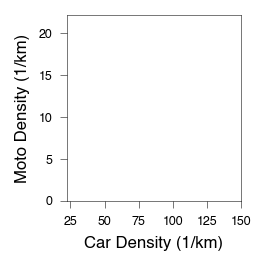

In [17]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    error_matrix,
    levels=arange(0.1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
# _ = plt.imshow(error_matrix.T, origin="lower")

In [ ]:
# _ = plt.plot(error_matrix[-1], c="k")

## Effect of traffic composition on the capacity

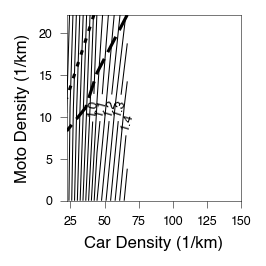

In [18]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
section = ax.contour(
    car_density,
    moto_density,
    percent_matrix,
    levels=[0, 0.25, 0.35],
    colors=[
        "none",
        "k",
        "k",
    ],
    linestyles=[
        "-",
        "--",
        ":",
    ],
    lw=1.75,
)
major = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars / 1000,
    levels=arange(0.45, 1.6, 0.05),
    colors="k",
    frameon=True,
    linewidths=0.5,
)
ax.clabel(major, major.levels[3::2][4:], inline=True, fontsize=6)
minor = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars,
    levels=arange(450, 1600, 1),
    colors="none",
    frameon=True,
    linewidths=0.5,
)
l_points, l_response = normalized(minor, section)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
fig.tight_layout(pad=0)
# plt.savefig(f"flow_surface.pdf", format="pdf", transparent=True)

In [ ]:
# _ = plt.imshow(flow_matrix_cars.T, origin="lower")

In [19]:
l_density = [
    78.85164336796137,
    80.21430502104938,
    81.76971482132372,
    84.2952412358987,
    121.4738292635279,
    126.26641429146008,
    129.25637641049116,
    132.76735019167575,
    136.07715448570178,
    139.55620001819193,
    140.61463808620402,
    143.44068363706938,
    147.31179201878675,
    55.277204341493906,
    56.350926415363226,
    56.728340987200056,
    59.15088612856629,
    47.49730502323255,
    47.88934040436746,
    57.64671875346068,
    58.15279998791782,
    59.00262311679693,
    59.839895783363254,
    67.74543008835644,
    85.85646285009275,
    88.13886959677079,
    90.813589412546,
    92.62579527487557,
    95.09407661086294,
    97.18538284222981,
    99.37074122699903,
    101.21331224133333,
    103.5857831721714,
    106.07214566317205,
    127.67537281967729,
    148.0210927334216,
    151.89620982152047,
    153.15095885255977,
    154.93836756645743,
    67.54819433406072,
    68.09284618743301,
    69.15848942390676,
    70.63181700666524,
    88.31011766872678,
    90.99282148135316,
    42.866514801061754,
    86.25373121166918,
    105.1148969935716,
    109.19596135736022,
    111.82669186663368,
    131.4579356178662,
    135.28949074125137,
    138.72787252345282,
    141.26102638279002,
    145.013847601388,
    147.7840554293003,
    80.14656707719867,
    81.1281440892312,
    88.98274159304249,
    100.22620105526924,
    103.35045179907183,
    105.46557297780107,
    106.92324136442195,
    108.67743619761646,
    111.28294271429696,
    114.57934532708677,
    118.2284520962177,
    120.84590917898109,
    122.44207397691194,
    124.41116276795671,
    125.93127139567115,
    127.48898604602456,
    130.3532186962445,
    134.70215310952977,
    137.08915451648053,
    141.47802606239614,
    53.708994790095524,
    54.210816156969244,
    42.30121005500219,
    42.76893332724363,
    33.847457586750686,
    74.0699377761518,
    109.57030073507198,
    113.59445814058193,
    116.00867202329493,
    118.37550144782684,
    120.84091986263321,
    122.92216595962665,
    125.92589397872716,
    131.08368980283393,
    136.6820472257816,
    149.69003222401113,
    154.67826099957523,
    73.42414686596992,
    75.14823533370938,
]
l_flow = [
    1558.0390273248458,
    1546.08105538972,
    1536.423693594767,
    1563.3005100398946,
    1178.0788527954155,
    1025.529308431304,
    1034.0376697399734,
    885.2577182971727,
    890.7181910575447,
    795.2277785736013,
    715.9356849125139,
    643.2863450707156,
    499.85247435434826,
    917.9660898864796,
    881.1661454829024,
    1457.8094140358965,
    1455.4988469635307,
    1174.542585524414,
    1137.8094812741908,
    1425.5245177454833,
    1466.2279320556374,
    1423.2511880505324,
    1472.4542604569156,
    1527.3576816256773,
    1509.022250248795,
    1420.965449839972,
    1408.9813979757166,
    1392.1987202958474,
    1337.106557463828,
    1331.265283872372,
    1300.9027626034924,
    1239.2550217286862,
    1205.447872494521,
    1170.0178738361903,
    510.6959480374308,
    663.8294493103753,
    533.9485994827373,
    482.81452544546846,
    469.53793878155653,
    1424.6828508167503,
    1411.4746581951968,
    1475.529256442378,
    1472.7253957843127,
    1552.1492717854715,
    1522.1920864073388,
    805.4509928448624,
    1526.5299661625768,
    1541.7883529109063,
    1588.320168709319,
    1463.9659738500616,
    1083.740224678931,
    1016.7227372364727,
    891.1374825203661,
    701.9861089717187,
    738.3347819645631,
    644.7278738607845,
    1573.8428515555174,
    1553.792234487093,
    1563.9655503885988,
    1482.313610175528,
    1352.9986995190175,
    1380.6884717577275,
    1347.9416489935177,
    1212.0161704967143,
    1187.1308696110573,
    1111.2141118304146,
    1017.5546007675445,
    908.1758513337813,
    920.1712585458981,
    874.6625674158905,
    778.6325179924138,
    649.1064420204723,
    663.6895863027673,
    538.8013127893385,
    481.89708505657933,
    411.47774531381936,
    1028.6527492987625,
    1038.2637513959137,
    984.533554463229,
    995.4194428748996,
    599.0385623165865,
    1122.3396637820515,
    1367.9433004251628,
    1252.9928331526405,
    1181.3149886039596,
    1061.7565327478894,
    1083.8698152031468,
    1057.95617599896,
    1083.8083837973725,
    1048.6588357073506,
    877.9972057636294,
    689.5854098524392,
    449.87010699758247,
    1335.067125169194,
    1393.6702734652763,
]
mask = array(l_flow) > 400
a_density = array(l_density)[mask]
a_flow = array(l_flow)[mask]

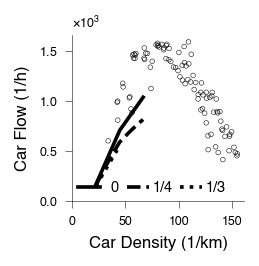

In [20]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
linestyles = [
    "-",
    "--",
    ":",
    "-.",
]
labels = ["  0", "1/4", "1/3"]
for n, (points, response) in enumerate(zip(l_points, l_response)):
    variable = []
    for point in l_points[n]:
        variable.append(point[0])
    l_variable = array(variable)
    order = np.argsort(variable)
    variable = np.sort(variable)
    response = array(l_response[n])[order]
    _ = plt.plot(
        variable,
        response,
        c="k",
        ls=linestyles[n],
        label=labels[n],
        clip_on=False,
        lw=1.75,
    )
plt.scatter(
    a_density,
    a_flow,
    ec="k",
    fc="none",
    s=5,
    lw=0.25,
    clip_on=False,
    zorder=10,
)
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Car Flow (1/h)")
ax.set_xlabel("Car Density (1/km)")
plt.legend(
    loc=(0, 0),
    frameon=False,
    handletextpad=0.25,
    handlelength=1.5,
    ncol=3,
    columnspacing=0.5,
    fontsize=7,
)
mf = mticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2, 2))
plt.gca().yaxis.set_major_formatter(mf)
fig.tight_layout(pad=0)
# plt.savefig(f"flow.pdf", format="pdf", transparent=True)

In [21]:
sigma = 0.1
gauss = gaussian_filter(speed_matrix_cars, [sigma, sigma], truncate=100)
speed_matrix_cars_f = gauss

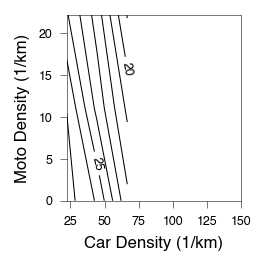

In [22]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_cars_f,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_cars.pdf", format="pdf", transparent=True)

In [ ]:
# _ = plt.imshow(speed_matrix_cars.T, origin="lower")

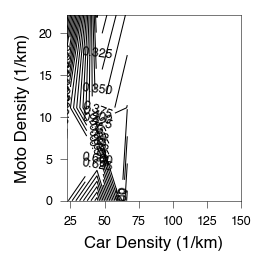

In [23]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_cars,
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels, inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
# _ = plt.imshow(sem_matrix_cars.T, origin="lower")

In [24]:
sigma = 0.5
gauss = gaussian_filter(speed_matrix_moto[:, 1:], [sigma, sigma], truncate=100)
speed_matrix_moto_f = np.hstack((speed_matrix_moto[:, 0][:, np.newaxis], gauss))

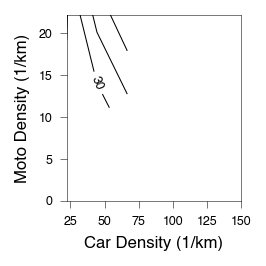

In [25]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_moto_f,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
fig.tight_layout(pad=0)  #
# plt.savefig(f"speed_moto.pdf", format="pdf", transparent=True)

In [ ]:
# _ = plt.imshow(speed_matrix_moto_f.T, origin="lower")

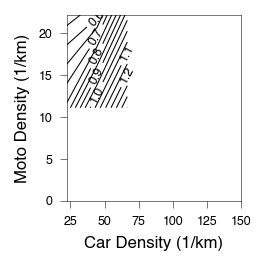

In [26]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_moto,
    levels=arange(0, 2, 0.05),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [27]:
# _ = plt.imshow(
#    sem_matrix_moto.T,
#    origin="lower",
# )

## Phase transitions

In [28]:
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [29]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [30]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(np.diff(np.sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [31]:
l_T_c = []
l_p_c = []
l_slope = []
r_values = []
p_values = []
for permutation in permutations:
    if permutation[0] > 2 and permutation[1] > 4:
        x, y, _, _ = results[str(permutation)]["percolation"]
        x, y = array(x), array(y)
        try:
            T_c = fit(x, y)
            renorm = np.abs(T_c - x)
            slope, intercept, r_value, p_value, std_err = linregress(
                np.log(renorm)[y > 0], np.log(y[y > 0])
            )
            r_values.append(r_value)
            p_values.append(p_value)
            p_c = 1 - T_c / T_max
            if r_value < 0.95:
                print(permutation, r_value)
                T_c = np.nan
                p_c = np.nan
            else:
                l_slope.append(slope)
        except:
            print(f"problem{permutation}")
            break
    else:
        T_c = np.nan
        p_c = np.nan
    l_T_c.append(T_c)
    l_p_c.append(p_c)
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
percolation_matrix = array(l_p_c).reshape((n_veh - 1, n_veh - 1))

In [32]:
np.mean(r_values), np.mean(p_values)

(np.float64(nan), np.float64(nan))

In [ ]:
# _ = plt.imshow(
#    percolation_matrix.T,
#    origin="lower",
# )

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density[1:, 3:],
    moto_density[1:, 3:],
    percolation_matrix[1:, 3:],
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(50, 175, 25))
ax.set_ylabel("Moto Density (1/km)")
ax.set_xlabel("Car Density (1/km)")
ax.clabel(surface, surface.levels[::8], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
markers = ["o-", "s-", "D-", "X-"]
for i in range(4):
    ax.plot(
        car_density[1:, i + 3],
        percolation_matrix[1:, i + 3],
        markers[i],
        c="k",
        lw=0.5,
        ms=3,
        mfc="w",
        mew=".75",
        label=f"$N={2*(i+3)}$",
    )
ax.set_ylabel("$p_c$")
ax.set_xlabel("Car Density (1/km)")
ax.legend(
    loc=[0, 0],
    frameon=False,
    handletextpad=0.25,
    labelspacing=0.3,
    handlelength=0.75,
    fontsize=7,
)
ax.text(
    0.95,
    0.95,
    "$p_c = 1-T_c/T_{max}$",
    ha="right",
    va="top",
    fontsize=7,
    transform=ax.transAxes,
)
# ax.set_xlim(25, 175)
ax.set_ylim(0, 0.8)
ax.set_xticks(arange(50, 175, 25))
ax.set_yticks(arange(0, 0.9, 0.1))
fig.tight_layout(pad=0)
# plt.savefig(f"criticality.pdf", format="pdf", transparent=True)

In [ ]:
def draw_law(x, y, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        markeredgewidth=0.7,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(np.unique(np.log(x)[y > 0])),
        np.exp(p_fitted(np.unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$={r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.05,
        0.8,
        f"$\\nu$={slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.95,
        0.05,
        f"$T_c=${T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.95,
        0.2,
        f"{permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
    )
    # ax.spines[["right", "top"]].set_visible(False)
    ax.set_ylabel("$\langle \Delta \Phi \\rangle^+$")
    ax.set_xlabel("$|T-T_c|$")
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

In [ ]:
# for permutation in permutations:
#    if permutation[0] > 2 and permutation[1] > 4:
#        x, y, low, high = results[str(permutation)]["percolation"]
#        x, y, low, high = array(x), array(y), array(low), array(high)
#        T_c = fit(array(x), y)
#        renorm = np.abs(T_c - x)
#        slope, intercept, r_value, p_value, std_err = linregress(
#            np.log(renorm)[y > 0], np.log(y[y > 0])
#        )
#        p_c = 1 - T_c / T_max
#        draw_law(renorm, y, save=True)

In [ ]:
permutation = (12, 8)
x, y, low, high = results[str(permutation)]["percolation"]
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(
    np.log(renorm)[y > 0], np.log(y[y > 0])
)
p_c = 1 - T_c / T_max
print(
    abs(NU - slope),
)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
ax.errorbar(
    x,
    y,
    yerr=high - low,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.5,
    ecolor="k",
    elinewidth=0.5,
    label="$\langle \Delta\Phi \\rangle$",
)
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axvline(T_c, c="k", lw=0.75, ls="--", label="$T_c$")

ax.set_ylabel("Percolation $\Delta\Phi$")
ax.set_xlabel("Temperature T")
ax.legend(
    loc=[0, 0],
    frameon=False,
    handletextpad=0.5,
    handlelength=1.5,
    fontsize=7,
)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

In [ ]:
draw_law(renorm, y, save=False)

## Animations

In [ ]:
non_empty = []
empty = []
items = None
n_cars = 12
n_moto = 8
permutation = (n_cars, n_moto)
n_cars, n_moto = permutation
load = True
if load:
    items = loader(permutation)
for item in items:
    if isinstance(item[0], list):
        non_empty.append(item)
    else:
        empty.append(item)
len(non_empty)

In [ ]:
item = non_empty[0]

In [ ]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
ring(frame, item[0], ax)

In [ ]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")


def animate_ring(i, ax=ax):
    ax.clear()
    ring(i, item[0], ax)


# Create the animation
ani_ring = animation.FuncAnimation(fig, animate_ring, frames=range(1, len(item[0]), 1))

In [ ]:
# Save the animation as an HTML video
ani_ring_html = ani_ring.to_jshtml()

In [ ]:
file = r"ring.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_ring.save(file, writer=writergif)

In [ ]:
def navi(t, l_agents, ID, ax):
    a_des = l_agents[t][ID - 1]["a_des"]
    a0 = l_agents[t][ID - 1]["a0"]
    alphas = l_agents[t][ID - 1]["alphas"]
    f_a = l_agents[t][ID - 1]["f_a"]
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.plot(np.degrees(alphas), f_a, c="k", clip_on=False)
    ax.scatter(np.degrees(a_des), 0, clip_on=False, marker="+", c="k")
    ax.spines["left"].set_position("zero")
    ax.set_xlabel("Direction $α$ ($\deg$)")
    ax.axhline(params.d_max, color="k", ls="--")
    ax.axvline(np.degrees(a0), color="k", ls=":")
    ax.text(np.degrees(a0) + 2, params.d_max + 0.5, "$α_0$")
    ax.set_ylim(0, params.d_max)
    ax.spines[["top", "right"]].set_visible(False)

In [ ]:
ID = 2 * n_cars + n_moto
ID

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
navi(frame, item[0], ID, ax)

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)


def animate_navi(i, ax=ax):
    ax.clear()
    ax = navi(i, item[0], ID, ax)


# Create the animation
ani_navi = animation.FuncAnimation(fig, animate_navi, frames=range(1, len(item[0]), 1))

In [ ]:
# Save the animation as an HTML video
ani_navi_html = ani_navi.to_jshtml()

In [ ]:
f = r"navi.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_navi.save(f, writer=writergif)